In [2]:
# Module load
from classifier_embedding import *
from classifier_model import *
import time

2024-02-23 10:46:43.007101: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 10:46:43.100179: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 10:46:43.100210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 10:46:43.100235: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 10:46:43.108254: I tensorflow/core/platform/cpu_feature_g

# MODEL

In [23]:
# Fix Model to XGBoost
model_name = 'XGB'
model_class = XGBClassifier(n_estimators=5000, device='cuda:0')
# Fix Protein Embedding to ESM650M and Compound Embedding to ChemBERTa
# Fix percentage of undersampling to 0.5
percentage = 0.5


# Load the data from IL36g retrospective target
SEED = 1234

# Load data
df_IL36 = load_data_to_model(pickle_file='data_retrospective/data_embed.pkl')

# if test 1 data sampled to 100.00, else test 2 full size data
#df_dude = load_data_to_model(pickle_file='ESM2650M-ChemBERT2/data_embed_100000.pkl')
df_dude = load_data_to_model(pickle_file='ESM2650M-ChemBERT2/data_embed.pkl')


Original dataset:
 - Number of active compounds:  7432
 - Number of inactive compounds (decoys):  141195
Original dataset:
 - Number of active compounds:  30538
 - Number of inactive compounds (decoys):  1407797


In [24]:
# Undersampling dataset from dude (training set)
X = df_dude['coembed'].tolist()
Y = df_dude['Label'].tolist()
X_res, Y_res = undersampling(Y, X, percentage=percentage)
df_dude_res = pd.DataFrame({'coembed': X_res, 'Label': Y_res})

Undersampling:
 - Original dataset shape Counter({0: 1407797, 1: 30538})
 - Resampled dataset shape Counter({0: 61076, 1: 30538})


In [25]:
# Train the model (dude) and test the model (IL36g)
X_train = df_dude_res['coembed'].tolist()
Y_train = df_dude_res['Label'].tolist()
X_test = df_IL36['coembed'].tolist()
Y_test = df_IL36['Label'].tolist()

splits = (X_train, X_test, Y_train, Y_test)
statistics_list = model_training_and_validation(model_class, splits=splits, verbose=True)
statistics_list = statistics_list[0:6]
print(statistics_list)


Accuracy: 0.95
Sensitivity: 0.00
Specificity: 1.00
AUC: 0.51
Precision: 0.03
F1: 0.01
Confusion matrix: {'tn': 140521, 'fp': 674, 'fn': 7408, 'tp': 24}
(0.9456222624422211, 0.0032292787944025836, 0.9952264598604766, 0.5069591006620371, 0.034383954154727794, 0.005904059040590407)


In [29]:
# Get the performance of the model
df_statistics = pd.DataFrame(statistics_list, columns=['IL36g_pred'])
index_names =['acc', 'sens', 'spec', 'auc', 'precision', 'f1']
df_statistics.index = index_names
df_statistics.to_csv('data_retrospective/statistics_prediction_IL36g_with_dude.csv')
df_statistics


,IL36g_pred
acc,0.945622
sens,0.003229
spec,0.995226
auc,0.506959
precision,0.034384
f1,0.005904


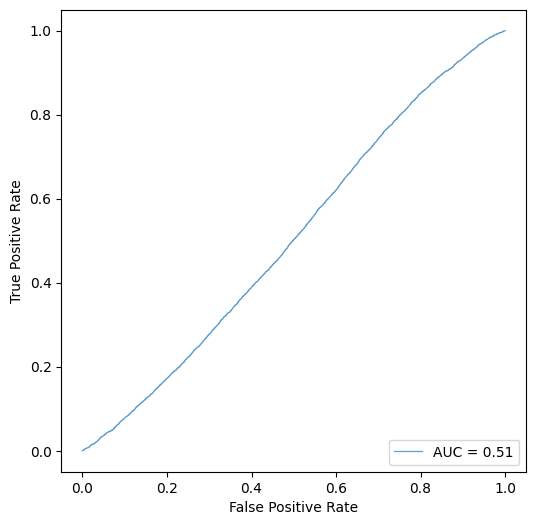

In [27]:
# Plot ROC
fig, ax = plt.subplots(figsize=(6, 6))
fpr, tpr, roc_thresh = roc_curve(Y_test, model_class.predict_proba(X_test)[:, 1], drop_intermediate=False)
display = RocCurveDisplay(fpr=fpr,
                            tpr=tpr,
                            roc_auc=roc_auc_score(Y_test, model_class.predict_proba(X_test)[:, 1])
)
display.plot(ax=ax, lw=0.9, alpha=0.7)

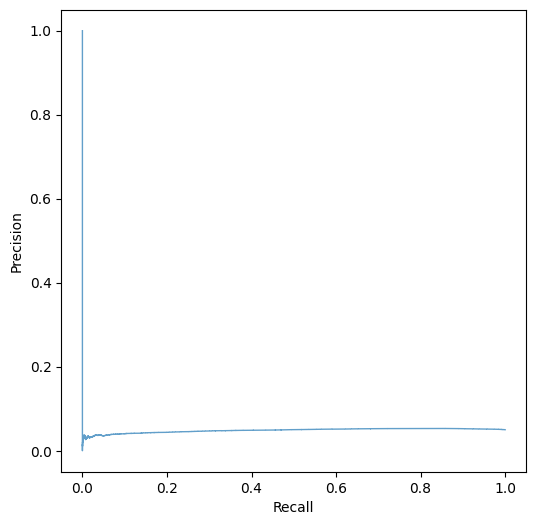

In [28]:
# Plot PR
fig, ax = plt.subplots(figsize=(6, 6))
precision, recall, pr_thresh = precision_recall_curve(Y_test, model_class.predict_proba(X_test)[:, 1])
display = PrecisionRecallDisplay(
    precision=precision,
    recall=recall,
)
display.plot(ax=ax, lw=1, alpha=0.7)